# Метрики классификации

Подключение необходимых библиотек

In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Генерация синтетических данных

In [2]:
X, Y = make_classification(n_samples = 10000, n_features = 10, n_classes = 2,
                           weights = [0.95, 0.05], flip_y = 0, random_state = 42)
print(type(X), type(Y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


Разделяем выборку на три - обучающую, валидационную и тестовую. <br>
Обучающую используем непосредственно для обучения (fit). <br>
Валидационную используем для подбора гиперпараметров. <br>
Тестовую для окончательной оценки модели.

In [3]:
X_train, X_tmp, Y_train, Y_tmp = train_test_split(X, Y, train_size = 0.8, shuffle = True, stratify = Y, random_state = 42)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_tmp, Y_tmp, train_size = 0.5, shuffle = True, stratify = Y_tmp, random_state = 42)

print('Train set size is', X_train.shape)
print('Valid set size is', X_valid.shape)
print('Test set size is', X_test.shape)

Train set size is (8000, 10)
Valid set size is (1000, 10)
Test set size is (1000, 10)


В качестве модели выбираем KNN классификатор

In [4]:
model = KNeighborsClassifier(n_neighbors = 5)
model.fit(X_train, Y_train)

Y_pred_train = model.predict(X_train)
Y_pred_valid = model.predict(X_valid)

Define accuracy function

In [5]:
def accuracy_fcn(y_true, y_pred):
    acc = sum(y_true == y_pred)/len(y_true)
    return acc

print('Train accuracy score is', accuracy_fcn(Y_train, Y_pred_train))
print('Valid accuracy score is', accuracy_fcn(Y_valid, Y_pred_valid))

Train accuracy score is 0.974
Valid accuracy score is 0.965


Строим метрики модели

In [6]:
accuracy = metrics.accuracy_score(Y_valid, Y_pred_valid)
precision = metrics.precision_score(Y_valid, Y_pred_valid)
recall = metrics.recall_score(Y_valid, Y_pred_valid)
f1 = metrics.f1_score(Y_valid, Y_pred_valid)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Accuracy: 0.96
Precision: 0.74
Recall: 0.46
F1 Score: 0.57


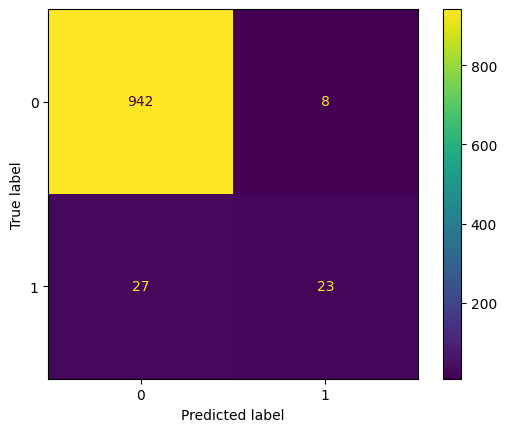

In [7]:
cmValid = metrics.confusion_matrix(Y_valid, Y_pred_valid)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cmValid)
disp.plot()

In [8]:
TN = cmValid[0,0]
TP = cmValid[1,1]
FP = cmValid[0,1]
FN = cmValid[1,0]
print('Validation confusion matrix')
print(TN, FP)
print(FN, TP)
R = TP/(TP+FN)
print('Recall score is', np.round(R,2))

Validation confusion matrix
942 8
27 23
Recall score is 0.46


Реализуем метод Grid Search

In [9]:
paramValidScores = []
paramDict = {'n_neighbors': np.arange(1, 16, 1)}
for key in paramDict:
    (key, paramDict[key])
    paramList = paramDict[key]
    for index in range(0, len(paramList), 1):
        optModel = KNeighborsClassifier(n_neighbors = 5)
        grid = {key:paramList[index]}
        optModel.set_params(**grid)
        print('Start training model with', key, '=', paramList[index])
        optModel.fit(X_train, Y_train)
        optModel_pred_valid = optModel.predict(X_valid)
        # set metric
        optModelScore = metrics.precision_score(Y_valid, optModel_pred_valid)
        print('Model score is', optModelScore)
        paramValidScores.append(optModelScore)
    bestValidScore = max(paramValidScores)
    bestScoreIndex = paramValidScores.index(bestValidScore)
    bestParamValue = paramDict[key][bestScoreIndex]
    print('Best validation score is', bestValidScore, key, '=', bestParamValue)

Start training model with n_neighbors = 1
Model score is 0.5
Start training model with n_neighbors = 2
Model score is 0.72
Start training model with n_neighbors = 3
Model score is 0.7058823529411765
Start training model with n_neighbors = 4
Model score is 0.7777777777777778
Start training model with n_neighbors = 5
Model score is 0.7419354838709677
Start training model with n_neighbors = 6
Model score is 0.75
Start training model with n_neighbors = 7
Model score is 0.7777777777777778
Start training model with n_neighbors = 8
Model score is 0.8333333333333334
Start training model with n_neighbors = 9
Model score is 0.7666666666666667
Start training model with n_neighbors = 10
Model score is 0.6956521739130435
Start training model with n_neighbors = 11
Model score is 0.7407407407407407
Start training model with n_neighbors = 12
Model score is 0.72
Start training model with n_neighbors = 13
Model score is 0.7407407407407407
Start training model with n_neighbors = 14
Model score is 0.75
St

In [10]:
# set best param and calculate test score
# final model evaluation
bestGrid = {key: bestParamValue}
optModel.set_params(**bestGrid)
optModel.fit(X_train, Y_train)
Y_pred_test = optModel.predict(X_test)
testScore = metrics.precision_score(Y_test, Y_pred_test)
print('Test precision is', testScore)

Test precision is 0.7142857142857143


Use GridSearchCV from sklearn

In [13]:
precision_scorer = metrics.make_scorer(metrics.precision_score)
gridSearch = GridSearchCV(estimator = KNeighborsClassifier(n_neighbors = 5), param_grid = paramDict, scoring = precision_scorer, cv = 5, verbose = 1)
gridSearch.fit(X_train, Y_train)
print("Best param is", gridSearch.best_params_)
print("Best CV score is", gridSearch.best_score_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best param is {'n_neighbors': 14}
Best CV score is 0.8794548626823191


Return best model instance <br>
Final evaluation on same test set

In [12]:
bestModel = gridSearch.best_estimator_
bestModel_Pred_test = bestModel.predict(X_test)
testScoreCV = metrics.precision_score(Y_test, bestModel_Pred_test)
print('Test precision is', testScoreCV)

Test precision is 0.7222222222222222
